In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import tables as tb
sys.path.insert(0, '../src/')
import deployer
import time
import warnings
warnings.filterwarnings("ignore")

Instanciate the forecaster, paths and additional parameters:

In [3]:
forecaster = deployer.Deployer()

data_path = '../data/input/example.h5'
predict_path = '../data/predictions/predictions.h5'
server = 'FogServer01'
year = '2010'
month = '03'
day = '22'
horizons = {0:1,1:11,2:31,3:61}
horizons_r = {v:k for k,v in horizons.items()}

Check for available dates:

In [4]:
with tb.open_file(data_path, 'r') as h5:
    available_days = h5.root.DataCenter.FogServer01._v_children.keys()
available_days

dict_keys(['2010-03-20', '2010-03-21', '2010-03-22', '2010-03-23', '2010-03-24', '2010-03-25'])

Generate predictions for a whole day:

In [5]:
tic = time.time() 
warnings.filterwarnings("ignore")
forecaster.forecast(now=pd.to_datetime(f'{year}/{month}/{day} 16:29:00'), reps=530)
print('it took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

it took 00:00:06 in total


Extract data and predictions:

In [6]:
n_sensors = 17
n_horizons = 4
n = f'{year}-{month}-{day}'
with tb.open_file(predict_path, 'r') as h5_preds,\
    tb.open_file(data_path, 'r') as h5_data:
    timestamps = h5_preds.root.DataCenter[server][n]._v_children.keys()
    timestamps = list(timestamps)
    preds = np.empty((len(timestamps), n_sensors, n_horizons))
    persistence = np.empty((len(timestamps), n_sensors, n_horizons))
    data = np.empty((len(timestamps), n_sensors))
    for idx, t in enumerate(timestamps):
        preds[idx] = h5_preds.root.DataCenter[server][n][t][:]
        data[idx] = h5_data.root.DataCenter[server][n][idx,1:]
        for hh,h in enumerate([1,11,31,61]):
            if idx-h > 0: persistence[idx,:,hh] = h5_data.root.DataCenter[server][n][idx-h,1:]
            else: persistence[idx,:,hh] = np.nan
    sensors = h5_data.root.DataCenter[server]._v_attrs['columns'][1:]
times = [pd.to_datetime(d) for d in timestamps]



Plot predictions and real data:

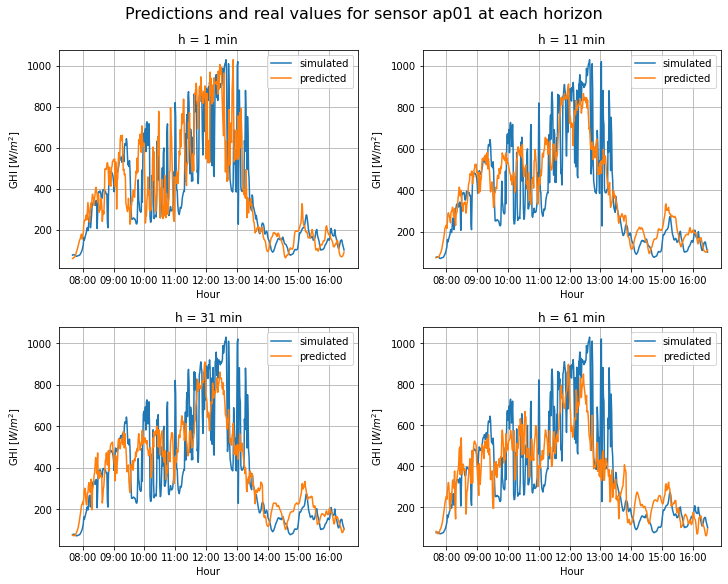

In [56]:
sensor = 0

fig,ax = plt.subplots(2,2, figsize=(10,8),constrained_layout = True)
fig.suptitle('Predictions and real values for sensor {} at each horizon'.format(sensors[sensor]), fontsize=16)
for idx,h in enumerate(['1 min','11 min','31 min','61 min']):
    ax[idx//2,idx%2].set_title(label='h = {}'.format(h))
    ax[idx//2,idx%2].plot(times, data[:,sensor], label='simulated')
    ax[idx//2,idx%2].plot(times, preds[:,sensor,idx], label='predicted')
    # ax[idx//2,idx%2].plot(times, persistence[:,sensor,idx], label='persistence')
    ax[idx//2,idx%2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[idx//2,idx%2].grid()
    ax[idx//2,idx%2].legend()
    ax[idx//2,idx%2].set_ylabel('GHI $[W/m^2]$')
    ax[idx//2,idx%2].set_xlabel('Hour') #, fontsize=12)

    # ax[i//3,i%3].set_xlabel('minutes since first prediction')

    # ax.plot(x, true)

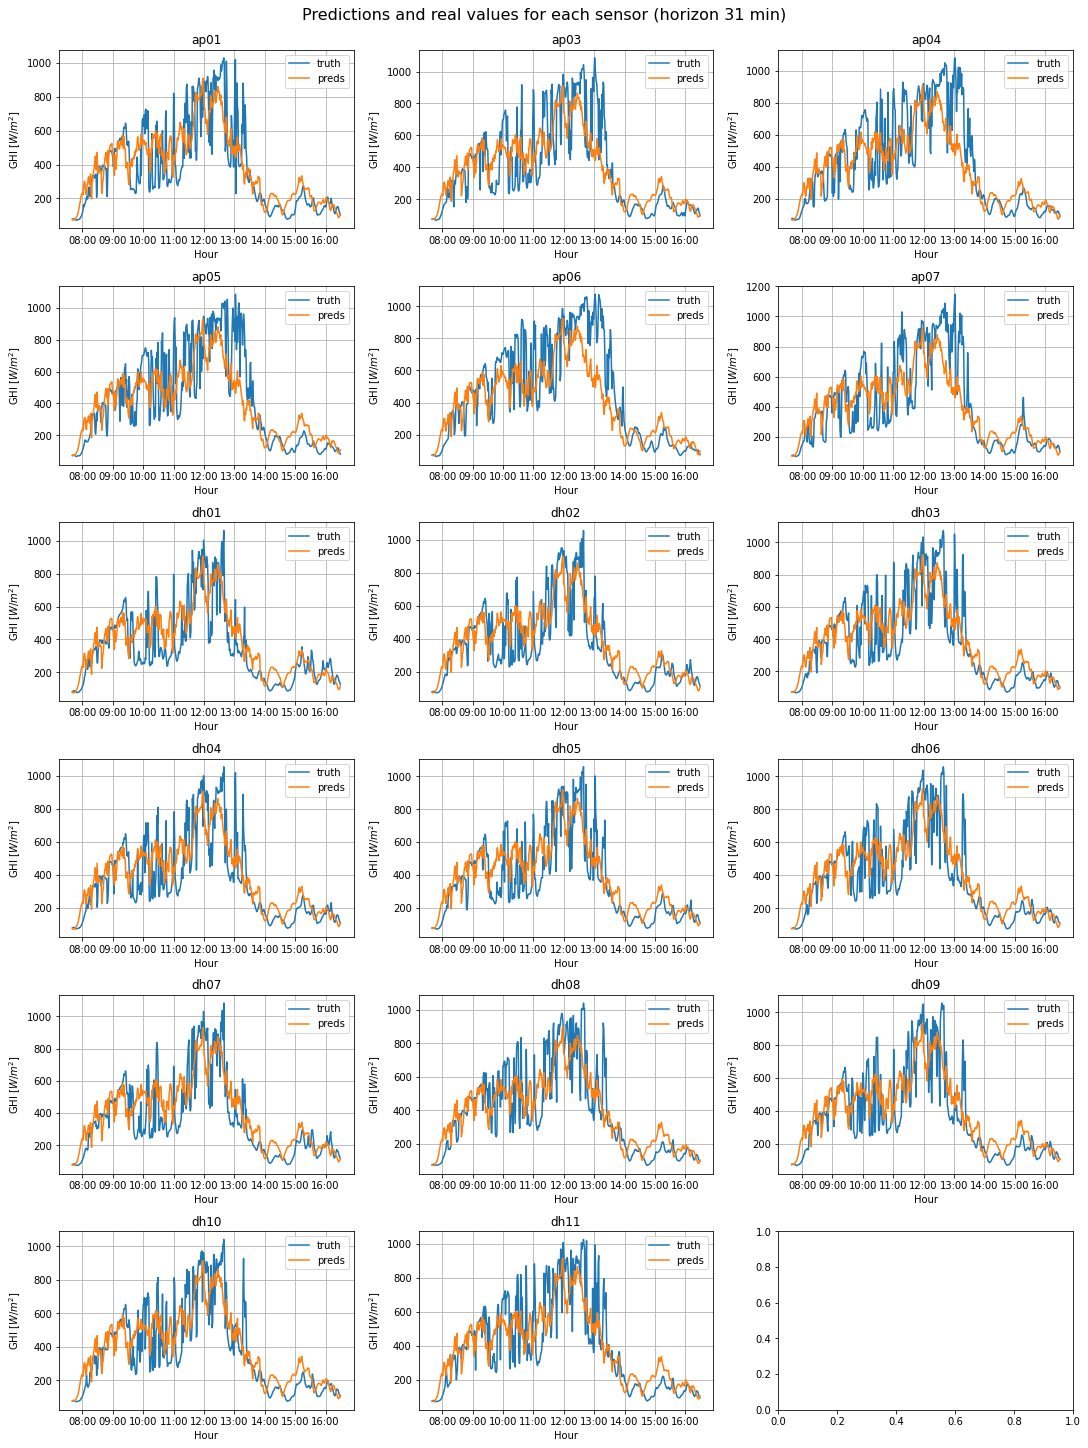

In [38]:
h = 2

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Predictions and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(17):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, data[:,i], label='truth')
    ax[i//3,i%3].plot(times, preds[:,i,h], label='preds')
    # ax[i//3,i%3].plot(times, persistence[:,i,h], label='persistence')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    ax[i//3,i%3].set_xlabel('Hour') #, fontsize=12)

    # ax[i//3,i%3].set_xlabel('minutes since first prediction')

    # ax.plot(x, true)

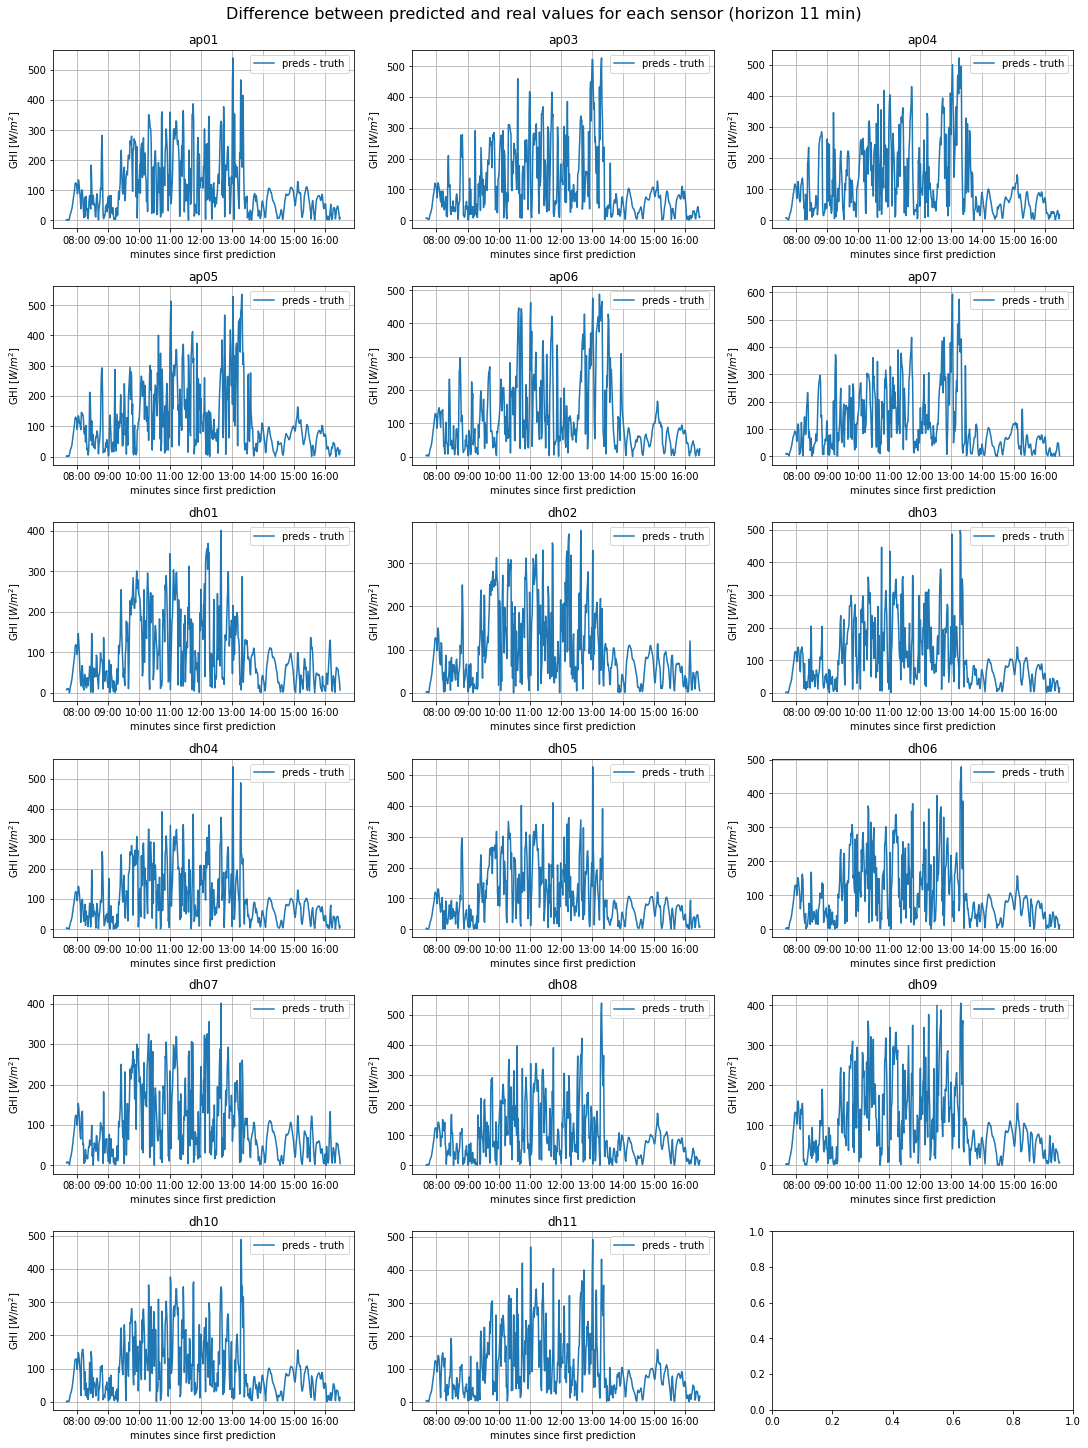

In [9]:
h =1

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Difference between predicted and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(17):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, np.abs(preds[:,i,h] - data[:,i]), label='preds - truth')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    ax[i//3,i%3].set_xlabel('minutes since first prediction')

Dataframes for MAE and RMSE for each horizon and each sensor:

In [10]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.nanmean(np.abs(preds[...,idx] - data), axis=0).round(2), np.nanmean(np.abs(preds[...,idx] - data), axis=(0,1)).round(2)]  
df.loc['mean'] = [
    *np.mean([np.abs(preds[...,j] - data) for j in range(4)], axis=(0,1)).round(2),
    np.mean([np.abs(preds[...,j] - data) for j in range(4)]).round(2)]
df.index.name = 'MAE'
df.T

MAE,1 min,11 min,31 min,61 min,mean
ap01,115.08,108.29,110.95,119.20,113.38
ap03,122.29,114.11,121.55,135.25,123.30
ap04,125.13,120.55,128.61,148.90,130.79
ap05,124.44,120.98,131.32,145.31,130.51
ap06,118.33,117.44,132.76,153.35,130.47
ap07,120.76,116.60,127.80,145.94,127.77
dh01,97.90,96.20,102.50,110.93,101.88
dh02,102.12,99.72,103.08,110.93,103.96
dh03,117.30,109.33,112.50,119.73,114.72
dh04,114.07,104.36,105.61,113.20,109.31


In [11]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=0)).round(2), np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=(0,1))).round(2)]  
df.loc['mean'] = [
    *np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)], axis=(0,1))).round(2),
    np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)])).round(2)]
df.index.name = 'RMSE'
df.T

RMSE,1 min,11 min,31 min,61 min,mean
ap01,166.32,144.70,145.88,158.76,154.18
ap03,174.74,157.32,165.68,186.65,171.44
ap04,175.90,163.38,175.28,205.09,180.57
ap05,175.82,163.26,176.67,198.66,179.05
ap06,168.05,161.41,180.84,212.83,181.86
ap07,173.28,159.92,173.02,197.55,176.47
dh01,143.40,127.47,132.59,141.59,136.42
dh02,145.71,130.62,132.45,142.10,137.87
dh03,170.97,144.41,146.86,159.29,155.75
dh04,164.02,138.06,138.16,150.87,148.17


Forecasting Skill of the model when compared with persistent: 

In [55]:
proposed_mae, base_mae = np.empty(4), np.empty(4)
proposed_rmse, base_rmse = np.empty(4), np.empty(4)
for idx,i in enumerate([1,11,31,61]):
    proposed_mae[idx] = np.nanmean(np.abs(preds[i+1:,:,idx] - data[i+1:]), axis=(0,1))
    base_mae[idx] = np.nanmean(np.abs(persistence[i+1:,...,idx] - data[i+1:]), axis=(0,1))
    proposed_rmse[idx] = np.nanmean(np.sqrt(np.nanmean((preds[i+1:,:,idx] - data[i+1:])**2, axis=0)),axis=0)
    base_rmse[idx] =np.nanmean(np.sqrt(np.nanmean((persistence[i+1:,...,idx] - data[i+1:])**2, axis=0)),axis=0) 

skill_mae = (1 - proposed_mae/base_mae)*100
skill_rmse = (1 - proposed_rmse/base_rmse)*100
skill = pd.DataFrame([skill_mae.round(2),skill_rmse.round(2)])
skill = skill.set_axis(['percentage skill MAE','percentage skill RMSE'], axis=0).set_axis(['1 min','11 min','31 min','61 min'], axis=1)
skill

,1 min,11 min,31 min,61 min
percentage skill MAE,-149.15,13.09,32.76,45.98
percentage skill RMSE,-85.22,20.98,33.78,44.58
